In [ ]:
!pip install pyLDAvis
!pip install openpyxl==3.0.0

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

4 -8.272897865732556 0.37665085474276283
   Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             3.0              0.6421   
1            1             3.0              0.5088   
2            2             2.0              0.9395   
3            3             2.0              0.6050   
4            4             0.0              0.7363   
5            5             1.0              0.9996   
6            6             2.0              0.5049   
7            7             1.0              0.6465   
8            8             1.0              0.4961   
9            9             3.0              0.5903   

                                            Keywords  \
0  gotong, royong, bayar, layan, halal, immunity,...   
1  gotong, royong, bayar, layan, halal, immunity,...   
2  darah, varian, beku, temu, batas, risiko, tula...   
3  darah, varian, beku, temu, batas, risiko, tula...   
4  tinggal, menteri, trio, terima, bahan, fakta, ...   
5  batas, surat, syarat, lay

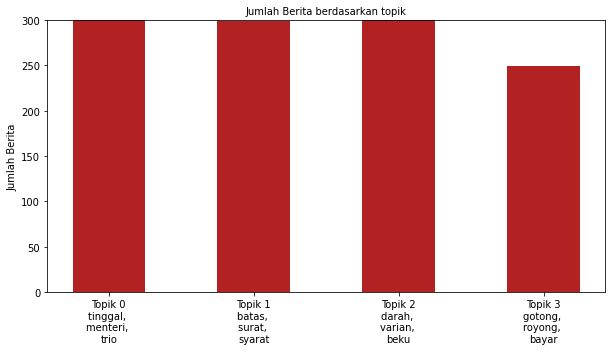

In [ ]:
# -*- coding: utf-8 -*-
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
import re
import pyLDAvis.gensim_models
import pickle 
import numpy as np, pandas as pd
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt

random_state = 0 

#Ganti_disini
df = pd.read_excel('dataset_Berita_V4.xlsx')
doc_set = df['Berita']
doc_set.str.split("\n")[1:-1]

#Ganti_disini
stopword = ['usia']

tokenizer = RegexpTokenizer(r'\w+')


# list for tokenized documents in loop
texts = []

# loop through document list
for i in doc_set.astype(str):
    
    # clean and tokenize document string
    raw = i.lower()
    raw =  re.sub(r'\b[0-9(.,)+]*\b', '', raw)
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in stopword and len(i) > 2]
    
    
    # add tokens to list
    texts.append(stopped_tokens)

# turn our tokenized documents into a id <-> term dictionary
dictionary = corpora.Dictionary(texts)
    
# convert tokenized documents into a document-term matrix
corpus = [dictionary.doc2bow(text) for text in texts]
#Ganti_disini
for k in range(4, 5):
	# generate LDA model
	ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=k, id2word = dictionary, passes=20, iterations=100, alpha=[0.01]*k, eta=[0.01]*len(dictionary.keys()))
	#print(ldamodel.show_topics())
	# Compute Coherence Score
	coherence_model_lda = CoherenceModel(model=ldamodel, texts=texts, dictionary=dictionary, coherence='c_v')
	coherence_lda = coherence_model_lda.get_coherence()
	print(k,ldamodel.log_perplexity(corpus),coherence_lda)  # a measure of how good the model is. lower the better.


def format_topics_sentences(ldamodel=None, corpus=corpus, texts=texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=ldamodel, corpus=corpus, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
pd.options.display.max_columns=50
print(df_dominant_topic.head(10))
df_dominant_topic.to_csv('df_dominant_topic.csv')

# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=ldamodel, corpus=corpus, start=0, end=4)  

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])

dominant_topic_in_each_doc = df_dominant_topic.groupby('Dominant_Topic').size()
print(dominant_topic_in_each_doc )
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()
df_dominant_topic_in_each_doc.to_csv('df_dominant_topic_in_each_doc.csv')

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()
df_topic_weightage_by_doc.to_csv('df_topic_weightage_by_doc.csv')

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in ldamodel.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)
df_top3words.to_csv('df_top3words.csv')

fig, ax1 = plt.subplots(figsize=(10,5))

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topik ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Jumlah Berita berdasarkan topik', fontdict=dict(size=10))
ax1.set_ylabel('Jumlah Berita')
ax1.set_ylim(0, 300)

plt.savefig('plot.png', dpi=300, bbox_inches='tight')
plt.show()
